<a href="https://colab.research.google.com/github/TomJiX/ML_start/blob/main/kaggle_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [2]:
import numpy as np
import pandas as pd 
from keras.utils import to_categorical, normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import time
import gc

#Import data

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c titanic


Saving kaggle.json to kaggle.json
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 47.8MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.28MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 61.6MB/s]


In [4]:
DATA="/content/train.csv"
TEST="/content/test.csv"

CHALLENGE_NAME="titanic"

# Load dataset.
dftrain = pd.read_csv(DATA)
dfeval = pd.read_csv(TEST)

dftrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Select usefull parameters

In [5]:
useful_columns=["Pclass","Sex","Age","SibSp","Parch","Survived"]
data_set=pd.read_csv(DATA,usecols=useful_columns)
data_set['FamilySize'] = data_set ['SibSp'] + data_set['Parch'] + 1
data_set['IsAlone']=(data_set['FamilySize']==1).astype(int)
data_set["male"] = (data_set["Sex"]=="male").astype(int)
data_set["female"] = (data_set["Sex"]=="female").astype(int)
data_set=data_set.drop("Sex",1)

sub_set=pd.read_csv(TEST,usecols=["Pclass","Sex","Age","SibSp","Parch"])
sub_set['FamilySize'] = sub_set ['SibSp'] + sub_set['Parch'] + 1
sub_set['IsAlone']=(sub_set['FamilySize']==1).astype(int)
sub_set["male"] = (sub_set["Sex"]=="male").astype(int)
sub_set["female"] = (sub_set["Sex"]=="female").astype(int)
sub_set=sub_set.drop("Sex",1)


for feature in data_set:
    feature_mean=np.nanmean(data_set[feature].to_numpy())
    data_set[feature] = data_set[feature].replace({ np.nan: feature_mean })
for feature in sub_set:
    feature_mean=np.nanmean(sub_set[feature].to_numpy())
    sub_set[feature] = sub_set[feature].replace({ np.nan: feature_mean })


labels_df = np.array(data_set['Survived'])# Remove the labels from the features
# axis 1 refers to the columns
features_df= data_set.drop('Survived', axis = 1)
# Saving feature names for later use
feature_list = list(features_df.columns)# Convert to numpy array
features = np.array(features_df)
submission = np.array(sub_set)

#Dataset data

In [6]:
DATA_SIZE=np.shape(features)
print(DATA_SIZE)

(891, 8)


#Model params

In [64]:
DENSE_LAYERS=list(range(1,7)) #6
LAYER_SIZE=[16,32,64]  #64
FAST_RUN=False
print("{} Number of models".format(len(DENSE_LAYERS)*len(LAYER_SIZE)))

18 Number of models


In [80]:
%rm -rf *-logs

In [ ]:
%%capture

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=2, 
                        verbose=1, 
                        factor=0.5, 
                        min_lr=0.00001)

EPOCHS=3 if FAST_RUN else 30
for dense_layer in DENSE_LAYERS:
        for layer_size in LAYER_SIZE:
            NAME = "{}-{}-dense-drop-{}".format(layer_size,dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Flatten(input_shape=(DATA_SIZE[1],)))

            for _ in range(dense_layer):
                model.add(Dense(layer_size,activation="relu"))
                #model.add(Dropout(0.25))

            model.add(Dense(1, activation='sigmoid')) # 2 because we have survive or not

            tensorboard = TensorBoard(log_dir="{}-logs19_11/{}".format(CHALLENGE_NAME,NAME))
            callbacks = [earlystop, learning_rate_reduction, tensorboard]
            model.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'],
                        )
            model.fit(features, labels_df,
                    batch_size=32,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    callbacks=callbacks)
            gc.collect()

%cp -R /content/*-logs* /content/drive/My\ Drive/Colab\ Notebooks/

Particular NN

In [75]:
DENSE_LAYERS=5 #5
LAYER_SIZE=64  #64
FAST_RUN=False

#print("{} Number of models".format())

In [76]:
%%capture
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization,Input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=2, 
                        verbose=1, 
                        factor=0.5, 
                        min_lr=0.00001)

def create_model():
    EPOCHS=3 if FAST_RUN else 30

    NAME = "{}-{}-dense-{}".format(LAYER_SIZE,DENSE_LAYERS, int(time.time()))
    print(NAME)

    model = Sequential()


    model.add(Input(shape=DATA_SIZE[1]))

    for _ in range(DENSE_LAYERS):
        model.add(Dense(LAYER_SIZE,activation="relu"))
        #model.add(Dropout(0.25))

    model.add(Dense(1,activation='sigmoid'))

    callbacks = [earlystop, learning_rate_reduction]
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

NN_model=create_model()
history=NN_model.fit(features, labels_df,
        batch_size=32,
        epochs=EPOCHS,
        validation_split=0.3,
        callbacks=callbacks)
gc.collect()
NN_model_acc=history.history['accuracy'][-1]

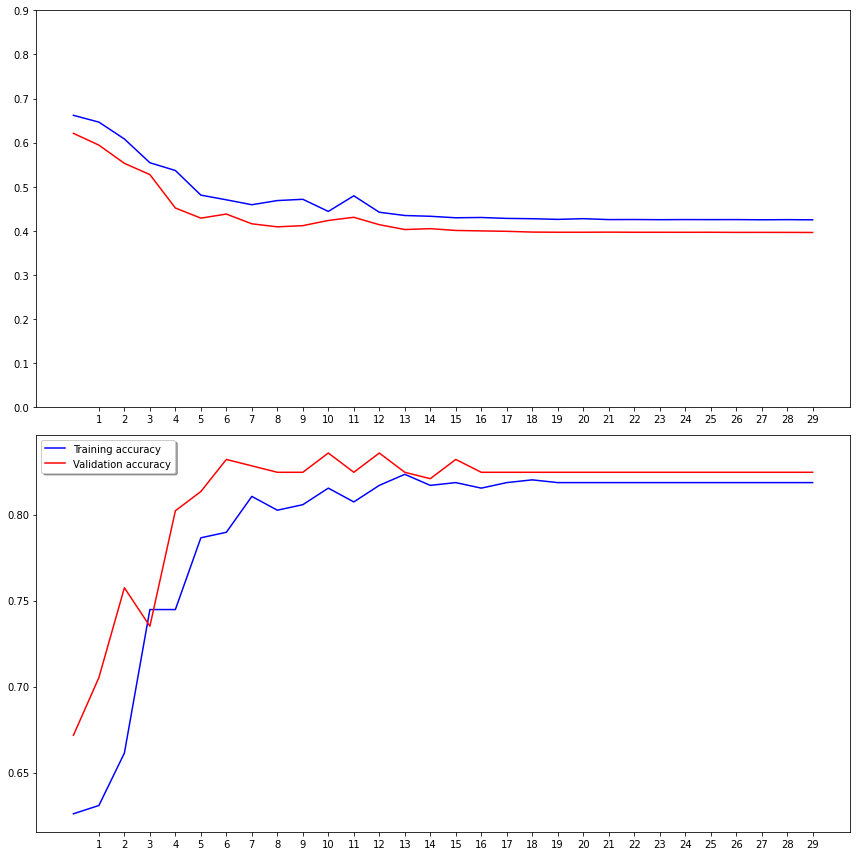

In [77]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Cross Validation

In [78]:
%%capture
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
n_split=10

cv=[]
for train_index,test_index in KFold(n_split).split(features):
    x_train,x_test=features[train_index],features[test_index]
    y_train,y_test=labels_df[train_index],labels_df[test_index]
    
    model=create_model()
    model.fit(x_train, y_train,epochs=20)
    cv.append(model.evaluate(x_test,y_test)[1])

cv_data=pd.DataFrame({'CV Mean':np.mean(cv),'Std':np.std(cv),"Model_acc":NN_model_acc},index=['NN_model'])


#Tensorboard

In [80]:
# %load_ext tensorboard
# %tensorboard --logdir /content/titanic-logs19_11

#Non NN models

In [81]:
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
import xgboost as xgb

In [82]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_df, test_size = 0.25, random_state = 42)

Try and Plot different classifier

In [83]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, shuffle=True) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
model_accuracy=[]
trained_models=[]
classifiers=['Linear Svm','Radial Svm','Decision Tree','Random Forest','Naive Bayes','Logistic Regression','KNN','XGBoost']
models=[svm.SVC(kernel='linear',C=0.1,gamma=0.1),svm.SVC(kernel='rbf',C=0.1,gamma=0.1),DecisionTreeClassifier(),RandomForestClassifier(n_estimators=100),GaussianNB(),LogisticRegression(),KNeighborsClassifier(),xgb.XGBClassifier(objective="binary:logistic", random_state=42)]
j=0
total=len(classifiers)
for i in models:
    model = i
    print("\r{} training... {}/{} Trained".format(classifiers[j],j,total),end="")
    j+=1
    model.fit(train_features,train_labels)
    trained_models.append(model)
    model_accuracy.append(metrics.accuracy_score(model.predict(test_features),test_labels))
    cv_result = cross_val_score(model,features_df,labels_df, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)

model_df=pd.DataFrame({'models':trained_models},index=classifiers)
model_df=pd.concat([model_df,pd.DataFrame({'models':NN_model},index=["NN_model"])])
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std,"Model_acc":model_accuracy},index=classifiers)
new_models_dataframe2=pd.concat([new_models_dataframe2,cv_data])
new_models_dataframe2

Logistic Regression training... 5/8 Trained

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


XGBoost training... 7/8 Trained

,CV Mean,Std,Model_acc
Linear Svm,0.787928,0.039384,0.784753
Radial Svm,0.686779,0.058618,0.609865
Decision Tree,0.784569,0.034650,0.730942
Random Forest,0.810375,0.039090,0.798206
Naive Bayes,0.796854,0.020404,0.798206
Logistic Regression,0.799151,0.028191,0.802691
KNN,0.785655,0.040522,0.820628
XGBoost,0.825006,0.030705,0.811659
NN_model,0.808090,0.038691,0.818620


In [84]:
print('Model with best accuracy : {}'.format(new_models_dataframe2['Model_acc'].idxmax(1)))
print('Model with best Cross validation mean : {}'.format(new_models_dataframe2['CV Mean'].idxmax(1)))

b_mod_name=(new_models_dataframe2['Model_acc']*1.1+new_models_dataframe2['CV Mean']*0.9).idxmax(1)
print('Model to choose : {}'.format(b_mod_name))
best_model=model_df['models'][b_mod_name]

Model with best accuracy : KNN
Model with best Cross validation mean : XGBoost
Model to choose : XGBoost


particular fit and bagging

In [85]:
ITER=10
CLASSIFIER= b_mod_name
print(CLASSIFIER)

XGBoost


In [86]:
classifiers=['Linear Svm','Radial Svm','Decision Tree','Random Forest','Naive Bayes','Logistic Regression','KNN','XGBoost']
models=[svm.SVC(kernel='linear',C=0.1,gamma=0.1),svm.SVC(kernel='rbf',C=0.1,gamma=0.1),DecisionTreeClassifier(),RandomForestClassifier(n_estimators=100),GaussianNB(),LogisticRegression(),KNeighborsClassifier(),xgb.XGBClassifier(objective="binary:logistic", random_state=42)]
j=0
stack_predic={}
for i in range(ITER):
    shuffle = np.array(sorted(np.c_[train_features,train_labels], key=lambda k: random.random()))
    model = models[classifiers.index(CLASSIFIER)]
    model.fit(np.array([x[:-1] for x in shuffle]),np.array([x[-1] for x in shuffle]))
    model_acc=metrics.accuracy_score(model.predict(test_features),test_labels)
    print("{}/{} Trained with acc={}".format(i+1,ITER,model_acc))
    stack_predic[CLASSIFIER+str(i)]=model.predict(submission)
    
stack_predic=pd.DataFrame(stack_predic)
stack_predic

1/10 Trained with acc=0.8116591928251121
2/10 Trained with acc=0.8116591928251121
3/10 Trained with acc=0.8116591928251121
4/10 Trained with acc=0.8116591928251121
5/10 Trained with acc=0.8116591928251121
6/10 Trained with acc=0.8116591928251121
7/10 Trained with acc=0.8116591928251121
8/10 Trained with acc=0.8116591928251121
9/10 Trained with acc=0.8116591928251121
10/10 Trained with acc=0.8116591928251121


,XGBoost0,XGBoost1,XGBoost2,XGBoost3,XGBoost4,XGBoost5,XGBoost6,XGBoost7,XGBoost8,XGBoost9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


feature importance

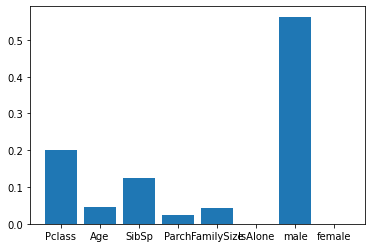

In [87]:
plt.bar(feature_list, model.feature_importances_)
plt.show()

In [88]:
sub_csv=pd.read_csv(TEST,usecols=['PassengerId'])
sub_csv["Survived"]=np.round(stack_predic.mean(1).to_numpy()).astype(int)
sub_csv.head()



,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [89]:
sub_csv.to_csv('submission.csv', index=False)
#!kaggle competitions submit -c titanic -f submission.csv -m "random tree 10"